# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will train your CNN-RNN model.  

You are welcome and encouraged to try out many different architectures and hyperparameters when searching for a good model.

This does have the potential to make the project quite messy!  Before submitting your project, make sure that you clean up:
- the code you write in this notebook.  The notebook should describe how to train a single CNN-RNN architecture, corresponding to your final choice of hyperparameters.  You should structure the notebook so that the reviewer can replicate your results by running the code in this notebook.  
- the output of the code cell in **Step 2**.  The output should show the output obtained when training the model from scratch.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Training Setup
- [Step 2](#step2): Train your Model
- [Step 3](#step3): (Optional) Validate your Model

<a id='step1'></a>
## Step 1: Training Setup

In this step of the notebook, you will customize the training of your CNN-RNN model by specifying hyperparameters and setting other options that are important to the training procedure.  The values you set now will be used when training your model in **Step 2** below.

You should only amend blocks of code that are preceded by a `TODO` statement.  **Any code blocks that are not preceded by a `TODO` statement should not be modified**.

### Task #1

Begin by setting the following variables:
- `batch_size` - the batch size of each training batch.  It is the number of image-caption pairs used to amend the model weights in each training step. 
- `vocab_threshold` - the minimum word count threshold.  Note that a larger threshold will result in a smaller vocabulary, whereas a smaller threshold will include rarer words and result in a larger vocabulary.  
- `vocab_from_file` - a Boolean that decides whether to load the vocabulary from file. 
- `embed_size` - the dimensionality of the image and word embeddings.  
- `hidden_size` - the number of features in the hidden state of the RNN decoder.  
- `num_epochs` - the number of epochs to train the model.  We recommend that you set `num_epochs=3`, but feel free to increase or decrease this number as you wish.  [This paper](https://arxiv.org/pdf/1502.03044.pdf) trained a captioning model on a single state-of-the-art GPU for 3 days, but you'll soon see that you can get reasonable results in a matter of a few hours!  (_But of course, if you want your model to compete with current research, you will have to train for much longer._)
- `save_every` - determines how often to save the model weights.  We recommend that you set `save_every=1`, to save the model weights after each epoch.  This way, after the `i`th epoch, the encoder and decoder weights will be saved in the `models/` folder as `encoder-i.pkl` and `decoder-i.pkl`, respectively.
- `print_every` - determines how often to print the batch loss to the Jupyter notebook while training.  Note that you **will not** observe a monotonic decrease in the loss function while training - this is perfectly fine and completely expected!  You are encouraged to keep this at its default value of `100` to avoid clogging the notebook, but feel free to change it.
- `log_file` - the name of the text file containing - for every step - how the loss and perplexity evolved during training.

If you're not sure where to begin to set some of the values above, you can peruse [this paper](https://arxiv.org/pdf/1502.03044.pdf) and [this paper](https://arxiv.org/pdf/1411.4555.pdf) for useful guidance!  **To avoid spending too long on this notebook**, you are encouraged to consult these suggested research papers to obtain a strong initial guess for which hyperparameters are likely to work best.  Then, train a single model, and proceed to the next notebook (**3_Inference.ipynb**).  If you are unhappy with your performance, you can return to this notebook to tweak the hyperparameters (and/or the architecture in **model.py**) and re-train your model.

### Question 1

**Question:** Describe your CNN-RNN architecture in detail.  With this architecture in mind, how did you select the values of the variables in Task 1?  If you consulted a research paper detailing a successful implementation of an image captioning model, please provide the reference.

**Answer:** 
* The CNN-RNN architecture is similar with the machine translation seq2seq model, it also includes the encoder and decoder parts but 'translates' an image to a sentence. Generally, in this case, the encoder takes the image as input, and output the context vector by using a pre-trainned CNN to extract the vectorial representation of image, then the decoder takes the context vector as the input, utilizing a LSTM model to generate a sequence of word, which is the caption corresponding to the input image.
* On the encoder side, I use the transfer learning method, that is, retainning the most parameters of the pre-trainned CNN, except replacing the last original fully connected layer with another fully connected layer, which outputs the pre-defined embedding size. In addition, I add a batch normailzation layer after that, to make the network more easy to train.
* On the decoder side, it is mainly a single layer LSTM model. On the trainning phase, the LSTM takes context vector from encoder as the first element of input sequence, and the annotated caption as the subsequent input except the <end\>. As a correspondence, the output sequence should be the whole annotated caption including <start\> and <end\>. The tokenized word should be transformed into embedding vectors with pre-defined embedding size using the embedding layer before feeding into the LSTM which has the input length of embedding size. The output vector on each time step is transformed by a fully connected layer connecting with the output of LSTM, with dimention of the vocabulary size. 
* I set the both **embed_size** and **hidden_size** to **512**, refered from the section 4.3.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf). And set the **batch_size** to **64**, refered from the section 4.3 of [this paper](https://arxiv.org/pdf/1502.03044.pdf). The **vocab_from_file** is set to **True** to load the vocabulary file created from **1_Preliminaries.ipynb**, and the related **vocab_threshold** is set to 5.


### (Optional) Task #2

Note that we have provided a recommended image transform `transform_train` for pre-processing the training images, but you are welcome (and encouraged!) to modify it as you wish.  When modifying this transform, keep in mind that:
- the images in the dataset have varying heights and widths, and 
- if using a pre-trained model, you must perform the corresponding appropriate normalization.

### Question 2

**Question:** How did you select the transform in `transform_train`?  If you left the transform at its provided value, why do you think that it is a good choice for your CNN architecture?

**Answer:**  
I have changed the input parameter of `transforms.Resize` in `transform_train` from a single integer 256 to a tuple (256, 256), means that it would resize the input image into a 256\*256 one, instead of resizing the shorter side into 256 with preserved aspect ratio.

That is because, there are many images with the aspect ratio of about 1.5:1, that is, take a 425\*650 image as an example, if we resize the shorter side into 256 with preserved aspect ratio, and corp it into size of 224\*224, thus the longer side would lost about 200 dimension which may have useful information about the caption.

I have trained the model using the new parameter, comparing with the provided value on the validation set using BLEU metric, I found that the BLEU score of the modified one is slightly better than the original one.

In addition, refered from setion 5.4 of [this paper](https://arxiv.org/pdf/1502.03044.pdf), the input image is resized so that the shortest side is 256 dimensional with preserved aspect ratio, and the input to the convolutional network is the center cropped 224x224 image. The difference is the method of cropping, changing from random crop to center crop. This might improve, but due to the limitation of resource, I haven't try this method.

### Task #3

Next, you will specify a Python list containing the learnable parameters of the model.  For instance, if you decide to make all weights in the decoder trainable, but only want to train the weights in the embedding layer of the encoder, then you should set `params` to something like:
```
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
```

### Question 3

**Question:** How did you select the trainable parameters of your architecture?  Why do you think this is a good choice?

**Answer:** 
* On the decoder, I make all weigths trainable. And on the encoder, I only train the new fully connected layer and the batch normalization layer.
* For the encoder, the images to be captioned are mostly similar with the images of ImageNet, so just directly using the pre-trained CNN which already has a good performance should well extract the features of input image, and the another significant benifit is to save large amount of training time.
* For the decoder, train all weights just because it is totally a new defined model. 

### Task #4

Finally, you will select an [optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Optimizer).

### Question 4

**Question:** How did you select the optimizer used to train your model?

**Answer:** 
* The optimization algorithm which I choose is Adam. Adma combines the features of both Momentum (Exponential Weighted Average) and RMSProp (Adaptive Learning), it has been tested by many people, proved working well both on classification and regression, and on CNN and RNN training. Its performance usually exceeds other algorithms, and it is often the first choice of optimization algorithm

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
!pip install nltk
import nltk
nltk.download('punkt')

## TODO #1: Select appropriate values for the Python variables below.
batch_size = 64          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize((320,320)),                    # smaller edge of image resized to 256
    transforms.RandomCrop(299),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.79s)
creating index...


  0%|          | 1204/414113 [00:00<01:12, 5677.03it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:01<00:00, 6729.07it/s]


In [10]:
% load_ext autoreload
% autoreload 2

from model import EncoderCNN, DecoderRNN, EncoderCNN_Others

# Initialize the encoder and decoder. 
encoder = EncoderCNN_Others(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.model.fc.parameters()) + list(encoder.bn.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='step2'></a>
## Step 2: Train your Model

Once you have executed the code cell in **Step 1**, the training procedure below should run without issue.  

It is completely fine to leave the code cell below as-is without modifications to train your model.  However, if you would like to modify the code used to train the model below, you must ensure that your changes are easily parsed by your reviewer.  In other words, make sure to provide appropriate comments to describe how your code works!  

You may find it useful to load saved weights to resume training.  In that case, note the names of the files containing the encoder and decoder weights that you'd like to load (`encoder_file` and `decoder_file`).  Then you can load the weights by using the lines below:

```python
# Load pre-trained weights before resuming training.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
```

While trying out parameters, make sure to take extensive notes and record the settings that you used in your various training runs.  In particular, you don't want to encounter a situation where you've trained a model for several hours but can't remember what settings you used :).

### A Note on Tuning Hyperparameters

To figure out how well your model is doing, you can look at how the training loss and perplexity evolve during training - and for the purposes of this project, you are encouraged to amend the hyperparameters based on this information.  

However, this will not tell you if your model is overfitting to the training data, and, unfortunately, overfitting is a problem that is commonly encountered when training image captioning models.  

For this project, you need not worry about overfitting. **This project does not have strict requirements regarding the performance of your model**, and you just need to demonstrate that your model has learned **_something_** when you generate captions on the test data.  For now, we strongly encourage you to train your model for the suggested 3 epochs without worrying about performance; then, you should immediately transition to the next notebook in the sequence (**3_Inference.ipynb**) to see how your model performs on the test data.  If your model needs to be changed, you can come back to this notebook, amend hyperparameters (if necessary), and re-train the model.

That said, if you would like to go above and beyond in this project, you can read about some approaches to minimizing overfitting in section 4.3.1 of [this paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7505636).  In the next (optional) step of this notebook, we provide some guidance for assessing the performance on the validation dataset.

### Model
* Inception V3

### Parameters
* batch_size = 64   
* embed_size = 512
* hidden_size = 512    

In [11]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/6471], Loss: 3.7861, Perplexity: 44.0847
Epoch [1/3], Step [200/6471], Loss: 3.3744, Perplexity: 29.2068
Epoch [1/3], Step [300/6471], Loss: 3.1901, Perplexity: 24.29042
Epoch [1/3], Step [400/6471], Loss: 2.8585, Perplexity: 17.4356
Epoch [1/3], Step [500/6471], Loss: 3.0314, Perplexity: 20.7265
Epoch [1/3], Step [600/6471], Loss: 3.0460, Perplexity: 21.0311
Epoch [1/3], Step [700/6471], Loss: 3.1149, Perplexity: 22.53104
Epoch [1/3], Step [800/6471], Loss: 2.5678, Perplexity: 13.0377
Epoch [1/3], Step [900/6471], Loss: 2.4057, Perplexity: 11.0858
Epoch [1/3], Step [1000/6471], Loss: 2.6294, Perplexity: 13.8649
Epoch [1/3], Step [1100/6471], Loss: 2.6294, Perplexity: 13.8653
Epoch [1/3], Step [1200/6471], Loss: 2.6503, Perplexity: 14.1590
Epoch [1/3], Step [1300/6471], Loss: 2.7136, Perplexity: 15.0829
Epoch [1/3], Step [1400/6471], Loss: 2.3926, Perplexity: 10.9422
Epoch [1/3], Step [1500/6471], Loss: 2.2008, Perplexity: 9.03258
Epoch [1/3], Step [1600/6471], L

FileNotFoundError: [Errno 2] No such file or directory: './models/decoder-1.pkl'

### Parameters
* batch_size = 64   
* embed_size = 512
* hidden_size = 512    

In [6]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/3], Step [100/6471], Loss: 3.6573, Perplexity: 38.7573
Epoch [1/3], Step [200/6471], Loss: 3.3401, Perplexity: 28.22131
Epoch [1/3], Step [300/6471], Loss: 2.9923, Perplexity: 19.9315
Epoch [1/3], Step [400/6471], Loss: 2.8869, Perplexity: 17.9374
Epoch [1/3], Step [500/6471], Loss: 2.9821, Perplexity: 19.7300
Epoch [1/3], Step [600/6471], Loss: 2.7285, Perplexity: 15.3095
Epoch [1/3], Step [700/6471], Loss: 2.8934, Perplexity: 18.0547
Epoch [1/3], Step [800/6471], Loss: 2.5743, Perplexity: 13.1218
Epoch [1/3], Step [900/6471], Loss: 2.4145, Perplexity: 11.1840
Epoch [1/3], Step [1000/6471], Loss: 2.3515, Perplexity: 10.5015
Epoch [1/3], Step [1100/6471], Loss: 2.9939, Perplexity: 19.9641
Epoch [1/3], Step [1200/6471], Loss: 2.5749, Perplexity: 13.1297
Epoch [1/3], Step [1300/6471], Loss: 2.2874, Perplexity: 9.84919
Epoch [1/3], Step [1400/6471], Loss: 2.3244, Perplexity: 10.2202
Epoch [1/3], Step [1500/6471], Loss: 2.4671, Perplexity: 11.7877
Epoch [1/3], Step [1600/6471], Lo

In [12]:
torch.save(decoder.state_dict(), os.path.join('./models', 'inception_v3_decoder-%d.pkl' % 1))
torch.save(encoder.state_dict(), os.path.join('./models', 'inception_v3_encoder-%d.pkl' % 1))

<a id='step3'></a>
## Step 3: (Optional) Validate your Model

To assess potential overfitting, one approach is to assess performance on a validation set.  If you decide to do this **optional** task, you are required to first complete all of the steps in the next notebook in the sequence (**3_Inference.ipynb**); as part of that notebook, you will write and test code (specifically, the `sample` method in the `DecoderRNN` class) that uses your RNN decoder to generate captions.  That code will prove incredibly useful here. 

If you decide to validate your model, please do not edit the data loader in **data_loader.py**.  Instead, create a new file named **data_loader_val.py** containing the code for obtaining the data loader for the validation data.  You can access:
- the validation images at filepath `'/opt/cocoapi/images/train2014/'`, and
- the validation image caption annotation file at filepath `'/opt/cocoapi/annotations/captions_val2014.json'`.

The suggested approach to validating your model involves creating a json file such as [this one](https://github.com/cocodataset/cocoapi/blob/master/results/captions_val2014_fakecap_results.json) containing your model's predicted captions for the validation images.  Then, you can write your own script or use one that you [find online](https://github.com/tylin/coco-caption) to calculate the BLEU score of your model.  You can read more about the BLEU score, along with other evaluation metrics (such as TEOR and Cider) in section 4.1 of [this paper](https://arxiv.org/pdf/1411.4555.pdf).  For more information about how to use the annotation file, check out the [website](http://cocodataset.org/#download) for the COCO dataset.

### Create the validation dataset

In [13]:
# (Optional) TODO: Validate your model.

# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader_val import get_loader_val
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize((320, 320)),                   # smaller edge of image resized to 256
    transforms.RandomCrop(299),                      # get 224x224 crop from random location    
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader_val = get_loader_val(transform=transform_test,
                                 batch_size=64,
                                 mode='val')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Vocabulary successfully loaded from vocab.pkl file!


In [14]:
def clean_sentence(output):
    sentence = ''
    for idx in output:
        if idx == 0:
            pass
        elif idx == 1:
            sentence = sentence[:-1]
            break
        else:
            ch = data_loader_val.dataset.vocab.idx2word[idx]
            if ch == '.':
                sentence = sentence[:-1]
            sentence += ch+' '
    
    return sentence

def get_prediction(image, gen='beam'):
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    
    if gen == 'greedy':
        output_sample = decoder.sample(features)
        sentence = clean_sentence(output_sample)

    if gen == 'beam':
        output_beam = decoder.beam_search_predictions(features, beam_index=20)
        sentence = clean_sentence(output_beam)

    return sentence

### Load the trained encoder and decoder

In [18]:
import os
import torch
from model import EncoderCNN, DecoderRNN, EncoderCNN_Others
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO #2: Specify the saved models to load.
encoder_file = 'inception_v3_encoder-1.pkl' 
decoder_file = 'inception_v3_decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader_val.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN_Others(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (lstm): LSTM(512, 512, batch_first=True)
  (embed): Embedding(8855, 512)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

In [24]:
image,_ = next(iter(data_loader_val))
caption = get_prediction(image[0].unsqueeze(0), gen='beam')
caption

'a red fire hydrant sitting on the side of a street.'

### Create captions on the validation set

In [25]:
# Evaluation the validation set
from collections import OrderedDict
import requests
import time
from tqdm import tqdm

old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

results = []

for i,(image,idx) in (enumerate(data_loader_val)):

    for j in (range(image.size(0))):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})

        caption = get_prediction(image[j].unsqueeze(0), gen='greedy')
        results.append(OrderedDict([('image_id', int(idx[j].view(-1).numpy()[0])), 
                                    ('caption', caption)]))
        
        print('\rBatch progress:{}/{}, '.format(j+1, image.size(0)), end='')
        
    print('Total progress:{}/{}'.format(i+1, len(data_loader_val)), end='')

    '''
    if i == 3:
        break
    '''

Batch progress:56/56, Total progress:633/633

#### Write the image id and captions into a JSON file

In [26]:
import json

with open('./result/captions_val2014_inception_epoch2_results.json', 'w') as f:
    json.dump(results, f)

### Caculate the BLEU score for each epoch

In [6]:
%matplotlib inline

import pandas as pd
import sys
sys.path.append('./coco-caption/')
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

# download Stanford models
!./coco-caption/get_stanford_models.sh

Found Stanford CoreNLP.


In [10]:
# set up file names and pathes
dataDir='/opt/cocoapi'
resultDir='.'
dataType='val2014'
model='inception'
algName = ['epoch1', 'epoch2', 'epoch3']
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtype='results'
resFile = \
['%s/result/captions_%s_%s_%s_%s.json'%(resultDir,dataType,model,alg,subtype) for alg in algName]

# create coco object and cocoRes object
coco = COCO(annFile)
df = pd.DataFrame(data=[[]], index=['BLEU_1', 'BLEU_2', 'BLEU_3', 'BLEU_4'])

for i,file in enumerate(resFile):
    cocoRes = coco.loadRes(file)

    # create cocoEval object by taking coco and cocoRes
    cocoEval = COCOEvalCap(coco, cocoRes)

    # evaluate on a subset of images by setting
    # cocoEval.params['image_id'] = cocoRes.getImgIds()
    # please remove this line when evaluating the full validation set
    cocoEval.params['image_id'] = cocoRes.getImgIds()

    # evaluate results
    # SPICE will take a few minutes the first time, but speeds up due to caching
    cocoEval.evaluate()
    
    scores = [s for _,s in cocoEval.eval.items()]
    df.insert(i, 'epoch_{}'.format(i+1), scores)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 371915, 'reflen': 375772, 'guess': [371915, 331411, 290907, 250403], 'correct': [245241, 110322, 43572, 17801]}
ratio: 0.9897357972387486
Bleu_1: 0.653
Bleu_2: 0.464
Bleu_3: 0.317
Bleu_4: 0.218
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 401629, 'reflen': 394896, 'guess': [401629, 361125, 320621, 280117], 'correct': [262504, 122782, 50965, 21557]}
ratio: 1.017050058749643
Bleu_1: 0.654
Bleu_2: 0.471
Bleu_3: 0.328
Bleu_4: 0.228
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 396121, 'reflen': 390892, 'guess': [396121, 355617, 315113, 27460

### Display the BLEU score of each epoch
#### from the score on validation data below, it shows that the model do NOT get overfitting and the training process could be kept on.

In [11]:
from IPython.display import display

display(df)

,epoch_1,epoch_2,epoch_3
BLEU_1,0.652598,0.653598,0.659844
BLEU_2,0.463680,0.471405,0.472624
BLEU_3,0.317051,0.328112,0.328795
BLEU_4,0.217606,0.228339,0.228045


#### Show a sample image

ground truth captions(image_id:283064)
A table with a huge glass vase and fake flowers come out of it.
A plant in a vase sits at the end of a table.
A vase with flowers in it with long stems sitting on a table with candles. 
Flowers in a clear vase sitting on a table.
A large centerpiece that is sitting on the edge of a dining table.


generated caption (Bleu_2 score 0.94)
a table with a vase and flowers in it


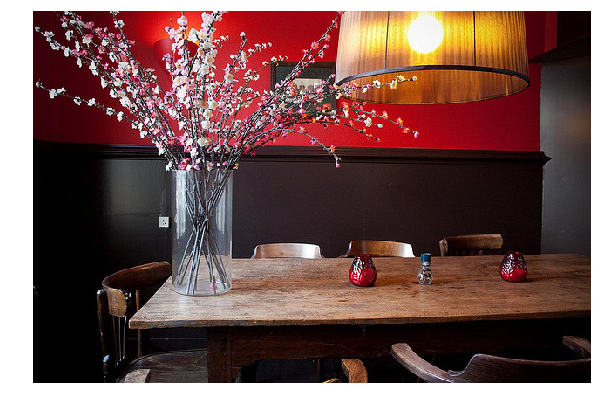

In [15]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_1']<1.0]
index = 1000
imgId = evals[index]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
print('ground truth captions(image_id:%d)'%imgId)
coco.showAnns(anns)

print('\n')
print('generated caption (Bleu_2 score %0.2f)'%(evals[index]['Bleu_2']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
dataDir = '/opt/cocoapi'
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()